### Convert N50 to Overture maps schema and parquet files

In [8]:
import geopandas as gpd
import pandas as pd
import fiona
import pyarrow as pa
import pyarrow.parquet as pq
from pathlib import Path

# --- 1. Konfigurasjon ---
fgdb_path = "C:\\dev\\datasets\\Basisdata_0000_Norge_25833_N50Kartdata_FGDB\\Basisdata_0000_Norge_25833_N50Kartdata_FGDB.gdb"
release = "2025-09-17"  # RELEASE-dato eller versjonsnummer
output_root = Path("overture_release") / release
output_root.mkdir(parents=True, exist_ok=True)



### NOT IN USE

Mapping from N50 produktspesifikasjon to Overture maps schema

In [2]:
# --- 2. Mapping N50 -> Overture ---

MAPPING = {
    # -----------------------
    # Administrative områder
    # -----------------------
    "AdministrativEnhet": ("admin", "administrativeBoundary", {}),
    "AdministrativGrense": ("admin", "administrativeBoundarySegment", {}),
    "AvtaltAvgrensningslinje": ("admin", "administrativeBoundarySegment", {}),
    "AvtalteGrenser": ("admin", "administrativeBoundarySegment", {}),
    "Fylkesgrense": ("admin", "administrativeBoundarySegment", {}),
    "Grunnlinje": ("admin", "administrativeBoundarySegment", {}),
    "Grunnlinjepunkt": ("admin", "administrativeBoundary", {"class": "baseline_point"}),
    "Kommune": ("admin", "administrativeBoundary", {"class": "municipality"}),
    "Kommunegrense": ("admin", "administrativeBoundarySegment", {}),
    "MaritimeGrenser": ("admin", "administrativeBoundarySegment", {"class": "maritime"}),
    "Riksgrense": ("admin", "administrativeBoundarySegment", {"class": "national"}),
    "Teiggrensepunkt": ("admin", "administrativeBoundary", {"class": "parcel_marker"}),
    "Territorialgrense": ("admin", "administrativeBoundarySegment", {"class": "territorial"}),

    # -----------------------
    # Arealdekke (land, vann)
    # -----------------------
    "Alpinbakke": ("land", "landcover", {"class": "ski_slope"}),
    "Arealbrukgrense": ("land", "boundary", {"class": "landuse"}),
    "BymessigBebyggelse": ("land", "landcover", {"class": "urban"}),
    "DyrketMark": ("land", "landcover", {"class": "farmland"}),
    "ElvBekk": ("land", "waterway", {"type": "river"}),
    "ElvBekkKant": ("land", "waterway", {"type": "riverbank"}),
    "FerskvannTørrfall": ("land", "waterbody", {"class": "dry_freshwater"}),
    "FerskvannTørrfallkant": ("land", "waterbody", {"class": "dry_freshwater_edge"}),
    "Flomløpkant": ("land", "waterway", {"class": "floodway"}),
    "Foss": ("land", "place", {"class": "waterfall"}),
    "Golfbane": ("land", "landcover", {"class": "golf_course"}),
    "Gravplass": ("land", "landcover", {"class": "cemetery"}),
    "Havflate": ("land", "waterbody", {"type": "sea"}),
    "Hyttefelt": ("land", "landcover", {"class": "cabin_area"}),
    "Industriområde": ("land", "landcover", {"class": "industrial"}),
    "Innsjø": ("land", "waterbody", {"type": "lake"}),
    "InnsjøRegulert": ("land", "waterbody", {"type": "reservoir"}),
    "Innsjøkant": ("land", "waterbody", {"class": "shoreline"}),
    "InnsjøkantRegulert": ("land", "waterbody", {"class": "regulated_shoreline"}),
    "Kystkontur": ("land", "waterbody", {"class": "coastline"}),
    "Lufthavn": ("land", "landcover", {"class": "airport"}),
    "Myr": ("land", "landcover", {"class": "wetland"}),
    "Park": ("land", "landcover", {"class": "park"}),
    "Rullebane": ("land", "landcover", {"class": "runway"}),
    "Skjær": ("land", "landcover", {"class": "rock"}),
    "Skog": ("land", "landcover", {"class": "forest"}),
    "SnøIsbre": ("land", "landcover", {"class": "glacier"}),
    "SportIdrettPlass": ("land", "landcover", {"class": "sports"}),
    "Steinbrudd": ("land", "landcover", {"class": "quarry"}),
    "Steintipp": ("land", "landcover", {"class": "landfill"}),
    "Tettbebyggelse": ("land", "landcover", {"class": "residential"}),
    "Tregruppe": ("land", "landcover", {"class": "tree_cluster"}),
    "ÅpentOmråde": ("land", "landcover", {"class": "open_area"}),

    # -----------------------
    # Bygninger og anlegg
    # -----------------------
    "Bygning": ("buildings", "building", {}),
    "Bygningsavgrensning": ("buildings", "buildingPart", {}),
    "Campingplass": ("buildings", "landuse", {"class": "camp_site"}),
    "Dam": ("buildings", "infrastructure", {"class": "dam"}),
    "Flytebrygge": ("buildings", "marineInfrastructure", {"class": "floating_pier"}),
    "Gruve": ("buildings", "landuse", {"class": "mine"}),
    "Hoppbakke": ("buildings", "sportsFacility", {"class": "ski_jump"}),
    "KaiBrygge": ("buildings", "marineInfrastructure", {"class": "quay"}),
    "Ledning": ("buildings", "utilityInfrastructure", {"class": "power_line"}),
    "LuftledningLH": ("buildings", "utilityInfrastructure", {"class": "overhead_line"}),
    "Lysløype": ("buildings", "transportation", {"class": "ski_track"}),
    "MastTele": ("buildings", "utilityInfrastructure", {"class": "mast"}),
    "Molo": ("buildings", "marineInfrastructure", {"class": "breakwater"}),
    "Navigasjonsinstallasjon": ("buildings", "marineInfrastructure", {"class": "navigation"}),
    "Parkeringsområde": ("buildings", "landuse", {"class": "parking"}),
    "Pir": ("buildings", "marineInfrastructure", {"class": "pier"}),
    "Reingjerde": ("buildings", "landuse", {"class": "fence"}),
    "Rørgate": ("buildings", "utilityInfrastructure", {"class": "pipeline"}),
    "Skitrekk": ("buildings", "transportation", {"class": "ski_lift"}),
    "Skytebaneinnretning": ("buildings", "landuse", {"class": "shooting_range"}),
    "SpesiellDetalj": ("buildings", "place", {"class": "special_detail"}),
    "Takkant": ("buildings", "buildingPart", {"class": "roof_edge"}),
    "Takriss": ("buildings", "buildingPart", {"class": "roof_outline"}),
    "Tank": ("buildings", "utilityInfrastructure", {"class": "tank"}),
    "Tankkant": ("buildings", "utilityInfrastructure", {"class": "tank_edge"}),
    "Taubane": ("buildings", "transportation", {"class": "cableway"}),
    "Tårn": ("buildings", "utilityInfrastructure", {"class": "tower"}),
    "Vindkraftverk": ("buildings", "utilityInfrastructure", {"class": "wind_turbine"}),

    # -----------------------
    # Høyde
    # -----------------------
    "Forsenkningskurve": ("land", "contourLine", {"class": "depression"}),
    "Hjelpekurve": ("land", "contourLine", {"class": "auxiliary"}),
    "Høydekurve": ("land", "contourLine", {"class": "contour"}),
    "Terrengpunkt": ("land", "elevationPoint", {}),
    "TrigonometriskPunkt": ("land", "elevationPoint", {"class": "trig_point"}),

    # -----------------------
    # Restriksjonsområder
    # -----------------------
    "Allmenning": ("land", "landuse", {"class": "commons"}),
    "Allmenninggrense": ("land", "boundary", {"class": "commons"}),
    "Naturverngrense": ("land", "boundary", {"class": "protected"}),
    "Naturvernområde": ("land", "landuse", {"class": "protected_area"}),
    "Naturvernpunkt": ("land", "place", {"class": "protected_point"}),
    "Skytefelt": ("land", "landuse", {"class": "military"}),
    "Skytefeltgrense": ("land", "boundary", {"class": "military"}),

    # -----------------------
    # Samferdsel
    # -----------------------
    "Bane": ("transportation", "railSegment", {}),
    "Barmarksløype": ("transportation", "pathSegment", {"class": "track"}),
    "Bilferjestrekning": ("transportation", "ferryRoute", {"class": "car_ferry"}),
    "GangSykkelveg": ("transportation", "pathSegment", {"class": "cycleway"}),
    "Jernbanelenke": ("transportation", "railSegment", {}),
    "Jernbanepunkt": ("transportation", "railStation", {}),
    "Passasjerferjestrekning": ("transportation", "ferryRoute", {"class": "passenger_ferry"}),
    "RuteGenerell": ("transportation", "route", {}),
    "Stasjon": ("transportation", "railStation", {}),
    "Sti": ("transportation", "pathSegment", {"class": "footpath"}),
    "Traktorveg": ("transportation", "pathSegment", {"class": "track"}),
    "Veglenke": ("transportation", "roadSegment", {}),
    "VegSenterlinje": ("transportation", "roadSegment", {}),
    "Vegsperring": ("transportation", "roadBarrier", {}),

    # -----------------------
    # Stedsnavn
    # -----------------------
    "FellesTekst": ("land", "place", {"class": "label"}),
    "PresentasjonTekst": ("land", "place", {"class": "label"}),
    "StedsnavnTekst": ("land", "place", {"class": "place_name"}),
}


### N50 specific mapping
* NOT perfect - need adjusting

In [9]:
# --- 2. Mapping FGDB-lag -> Overture ---
MAPPING = {
# Administrative områder
"N50_AdministrativeOmråder_omrade": ("admin", "administrativeBoundary", {}),
"N50_AdministrativeOmråder_grense": ("admin", "administrativeBoundarySegment", {}),
"N50_AdministrativeOmråder_posisjon": ("admin", "administrativeBoundary", {"class": "marker"}),


# Arealdekke
"N50_Arealdekke_omrade": ("land", "landcover", {}),
"N50_Arealdekke_grense": ("land", "boundary", {}),
"N50_Arealdekke_senterlinje": ("land", "waterway", {}),
"N50_Arealdekke_posisjon": ("land", "place", {"class": "landcover_point"}),


# Bygninger og anlegg
"N50_BygningerOgAnlegg_omrade": ("buildings", "building", {}),
"N50_BygningerOgAnlegg_grense": ("buildings", "buildingPart", {}),
"N50_BygningerOgAnlegg_posisjon": ("buildings", "building", {"class": "point"}),
"N50_BygningerOgAnlegg_senterlinje": ("buildings", "utilityInfrastructure", {}),


# Samferdsel
"N50_Samferdsel_senterlinje": ("transportation", "roadSegment", {}),
"N50_Samferdsel_posisjon": ("transportation", "place", {"class": "transport_point"}),


# Restriksjonsområder
"N50_Restriksjonsområder_omrade": ("land", "landuse", {"class": "protected_area"}),
"N50_Restriksjonsområder_grense": ("land", "boundary", {"class": "protected"}),


# Høyde
"N50_Høyde_senterlinje": ("land", "contourLine", {}),
"N50_Høyde_posisjon": ("land", "elevationPoint", {}),


# Stedsnavn
"N50_Stedsnavn_tekstplassering": ("land", "place", {"class": "place_name"}),
}

# Read layers, convert and partition

Expected output is thousands of files in directories like this:
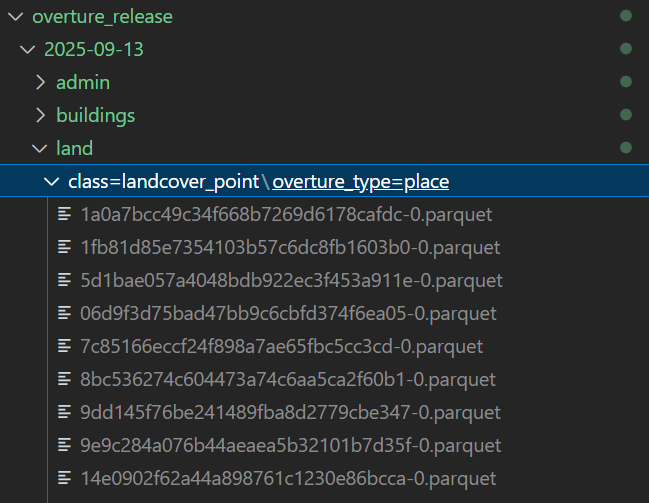

In [ ]:
import argparse
import pyogrio
import pandas as pd
from pathlib import Path

### NOT necessary
# --- 1. Parse arguments ---
parser = argparse.ArgumentParser(description="Convert N50 FGDB to Overture GeoParquet with batching (pyogrio)")
parser.add_argument("--fgdb", type=str, default="N50_Kartdata.gdb", help="Path to N50 FGDB")
parser.add_argument("--release", type=str, default="2025-09-13", help="Release version/date")
parser.add_argument("--batch_size", type=int, default=10000, help="Number of features per batch")
args = parser.parse_args()

#fgdb_path = args.fgdb
release = args.release
batch_size = args.batch_size

output_root = Path("overture_release") / release
output_root.mkdir(parents=True, exist_ok=True)

# --- 2. Mapping FGDB-lag -> Overture ---
MAPPING = {
    "N50_AdministrativeOmråder_omrade": ("admin", "administrativeBoundary", {}),
    "N50_AdministrativeOmråder_grense": ("admin", "administrativeBoundarySegment", {}),
    "N50_AdministrativeOmråder_posisjon": ("admin", "administrativeBoundary", {"class": "marker"}),
    "N50_Arealdekke_omrade": ("land", "landcover", {}),
    "N50_Arealdekke_grense": ("land", "boundary", {}),
    "N50_Arealdekke_senterlinje": ("land", "waterway", {}),
    "N50_Arealdekke_posisjon": ("land", "place", {"class": "landcover_point"}),
    "N50_BygningerOgAnlegg_omrade": ("buildings", "building", {}),
    "N50_BygningerOgAnlegg_grense": ("buildings", "buildingPart", {}),
    "N50_BygningerOgAnlegg_posisjon": ("buildings", "building", {"class": "point"}),
    "N50_BygningerOgAnlegg_senterlinje": ("buildings", "utilityInfrastructure", {}),
    "N50_Samferdsel_senterlinje": ("transportation", "roadSegment", {}),
    "N50_Samferdsel_posisjon": ("transportation", "place", {"class": "transport_point"}),
    "N50_Restriksjonsområder_omrade": ("land", "landuse", {"class": "protected_area"}),
    "N50_Restriksjonsområder_grense": ("land", "boundary", {"class": "protected"}),
    "N50_Høyde_senterlinje": ("land", "contourLine", {}),
    "N50_Høyde_posisjon": ("land", "elevationPoint", {}),
    "N50_Stedsnavn_tekstplassering": ("land", "place", {"class": "place_name"}),
}

# --- 3. Hive-partitioned lagring med batching (pyogrio) ---
def save_partitioned_batch_pyogrio(df, theme, overture_type, extra, base_dir, partition_cols):
    if df.empty:
        return
    df = df.copy()
    df["overture_type"] = overture_type
    for k, v in extra.items():
        df[k] = v
    # Write to partitioned GeoParquet with bbox columns
    pyogrio.write_dataframe(
        df,
        path=str(base_dir),
        driver="GeoParquet",
        partition_cols=partition_cols,
        bbox=True,
        append=True
    )
    print(f"   → Lagret batch på {len(df)} features til {base_dir}")

# --- 4. Les FGDB lag for lag i batches med pyogrio ---
layers = pyogrio.list_layers(args.fgdb)
print("Lag i FGDB:", [l[0] for l in layers])

for layer, _ in layers:
    if layer not in MAPPING:
        print(f"⚠️ Hopper over {layer}, ingen mapping definert")
        continue
    theme, overture_type, extra = MAPPING[layer]
    print(f"Behandler {layer} → {theme}/{overture_type}")
    # Read in batches
    total = pyogrio.get_layer_feature_count(args.fgdb, layer=layer)
    for start in range(0, total, batch_size):
        df = pyogrio.read_dataframe(
            args.fgdb,
            layer=layer,
            skip_features=start,
            max_features=min(batch_size, total - start)
        )
        if df.empty:
            continue
        base_dir = output_root / theme
        partition_cols = list(extra.keys()) + ["overture_type"]
        save_partitioned_batch_pyogrio(df, theme, overture_type, extra, base_dir, partition_cols)


In [19]:
#duck query in python
import duckdb
con = duckdb.connect(database=':memory:')
con.execute("INSTALL httpfs; LOAD httpfs;")
#install spatial extension
con.execute("INSTALL spatial; LOAD spatial;")

query = """
SELECT
*
FROM
read_parquet('.\\overture_release\\2025-09-13\\land\\overture_type=waterway\\*', filename=true, hive_partitioning=1)

LIMIT 100

"""
res = con.execute(query)
# display results
res.df()


,objtype,datafangstdato,oppdateringsdato,vannbredde,malemetode,noyaktighet,SHAPE_Length,geometry,filename,overture_type
0,ElvBekk,1984-07-01T00:00:00+00:00,2018-06-27T00:00:00+00:00,2,ska,2500,57.084806,"[1, 5, 0, 0, 0, 1, 0, 0, 0, 1, 2, 0, 0, 0, 4, ...",.\overture_release\2025-09-13\land\overture_ty...,waterway
1,ElvBekk,1958-07-01T00:00:00+00:00,2018-11-21T00:00:00+00:00,2,ska,2500,90.867642,"[1, 5, 0, 0, 0, 1, 0, 0, 0, 1, 2, 0, 0, 0, 7, ...",.\overture_release\2025-09-13\land\overture_ty...,waterway
2,ElvBekk,2007-07-04T00:00:00+00:00,2019-02-19T00:00:00+00:00,3,ska,500,1934.369530,"[1, 5, 0, 0, 0, 1, 0, 0, 0, 1, 2, 0, 0, 0, 195...",.\overture_release\2025-09-13\land\overture_ty...,waterway
3,ElvBekk,1984-07-01T00:00:00+00:00,2018-10-05T00:00:00+00:00,2,ska,2500,722.400730,"[1, 5, 0, 0, 0, 1, 0, 0, 0, 1, 2, 0, 0, 0, 30,...",.\overture_release\2025-09-13\land\overture_ty...,waterway
4,ElvBekk,2011-06-04T00:00:00+00:00,2018-03-26T00:00:00+00:00,2,ska,500,991.893993,"[1, 5, 0, 0, 0, 1, 0, 0, 0, 1, 2, 0, 0, 0, 105...",.\overture_release\2025-09-13\land\overture_ty...,waterway
...,...,...,...,...,...,...,...,...,...,...
95,ElvBekk,1993-07-01T00:00:00+00:00,2018-03-02T00:00:00+00:00,3,fot,2500,490.272302,"[1, 5, 0, 0, 0, 1, 0, 0, 0, 1, 2, 0, 0, 0, 47,...",.\overture_release\2025-09-13\land\overture_ty...,waterway
96,ElvBekk,1989-07-01T00:00:00+00:00,2018-10-09T00:00:00+00:00,2,fot,2500,2170.914388,"[1, 5, 0, 0, 0, 1, 0, 0, 0, 1, 2, 0, 0, 0, 137...",.\overture_release\2025-09-13\land\overture_ty...,waterway
97,ElvBekk,1990-07-01T00:00:00+00:00,2018-03-02T00:00:00+00:00,2,fot,2500,2139.662221,"[1, 5, 0, 0, 0, 1, 0, 0, 0, 1, 2, 0, 0, 0, 76,...",.\overture_release\2025-09-13\land\overture_ty...,waterway
98,ElvBekk,1993-07-01T00:00:00+00:00,2018-03-02T00:00:00+00:00,2,fot,2500,1756.898381,"[1, 5, 0, 0, 0, 1, 0, 0, 0, 1, 2, 0, 0, 0, 53,...",.\overture_release\2025-09-13\land\overture_ty...,waterway
